In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd

In [16]:
!pip install git+https://github.com/quantopian/pyfolio
# import again if first time not work
import pyfolio

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-9bsp2gby
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-9bsp2gby
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp36-none-any.whl size=75766 sha256=adb084a2f008712406da91ff10713beb0eebbf237817fd3181cfeb8d53ca2846
  Stored in directory: /tmp/pip-ephem-wheel-cache-19ef8ica/wheels/62/7d/a7/3e462442ba7d63c35414176627c886340521dc3dbc0893ce9f
Successfully built pyfolio


In [17]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [18]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df

In [19]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [20]:
def get_account_value(model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format(model_name,i))
        df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(sharpe)
    df_account_value=df_account_value.join(df_trade_date[105:].reset_index(drop=True))
    return df_account_value

In [22]:
!cp -a "drive/My Drive/Backtest_1213/model/" .
!cp -a "drive/My Drive/Backtest_1213/preprocessing/" .
!cp -a "drive/My Drive/Backtest_1213/config/" .
!cp -a "drive/My Drive/Backtest_1213/env/" .
!cp -a "drive/My Drive/Backtest_1213/data/" .
!cp -a "drive/My Drive/Backtest_1213/results/" .

## DJIA

In [23]:
dji = pd.read_csv("data/^DJI.csv")
test_dji=dji[(dji['Date']>='2016-01-01') & (dji['Date']<='2020-06-30')]
test_dji = test_dji.reset_index(drop=True)

In [24]:
test_dji.shape

(1131, 7)

In [25]:
test_dji.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,17405.480469,17405.480469,16957.630859,17148.939453,17148.939453,148060000
1,2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000
2,2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000
3,2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000
4,2016-01-08,16519.169922,16651.890625,16314.570313,16346.450195,16346.450195,141850000


In [26]:
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

In [27]:
dow_strat = backtest_strat(test_dji)

## Ensemble Strategy

In [28]:
df=pd.read_csv('data/dow_30_2009_2020.csv')

In [29]:
rebalance_window = 105
validation_window = 105
unique_trade_date = df[(df.datadate > 20151001)&(df.datadate <= 20200707)].datadate.unique()


In [30]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

In [31]:
ensemble_account_value = get_account_value('ensemble')

1.2673331297340429


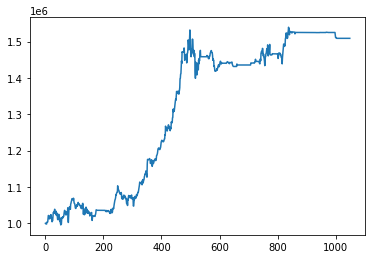

In [32]:
ensemble_account_value.account_value.plot()

In [33]:
ensemble_account_value = get_daily_return(ensemble_account_value)

Sharpe:  1.2673331297340429


In [34]:
ensemble_account_value['Date'] = test_dji['Date']

In [35]:
ensemble_account_value.head()

,account_value,datadate,daily_return,Date
0,1.000000e+06,20160304,NaN,2016-01-04
1,1.000521e+06,20160307,0.000521,2016-01-05
2,9.983000e+05,20160308,-0.002220,2016-01-06
3,9.981442e+05,20160309,-0.000156,2016-01-07
4,9.979063e+05,20160310,-0.000238,2016-01-08


In [36]:
ensemble_strat = backtest_strat(ensemble_account_value[0:1097])

In [37]:
#ensemble_account_value.to_csv('results/df_account_value_ensemble_daily_return.csv',index=False)

Start date,2016-01-04
End date,2020-03-05
Total months,50
,Backtest
Annual return,10.374%
Cumulative returns,50.875%
Annual volatility,8.053%
Sharpe ratio,1.27
Calmar ratio,1.19
Stability,0.86
Max drawdown,-8.684%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.68,2017-12-22,2018-01-23,2019-05-03,356
1,5.70,2016-05-23,2016-08-23,2016-12-16,150
2,5.06,2016-12-28,2017-03-20,2017-04-18,80
3,4.15,2016-02-19,2016-03-21,2016-04-25,47
4,3.86,2016-04-25,2016-04-27,2016-05-03,7


/usr/local/lib/python3.6/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


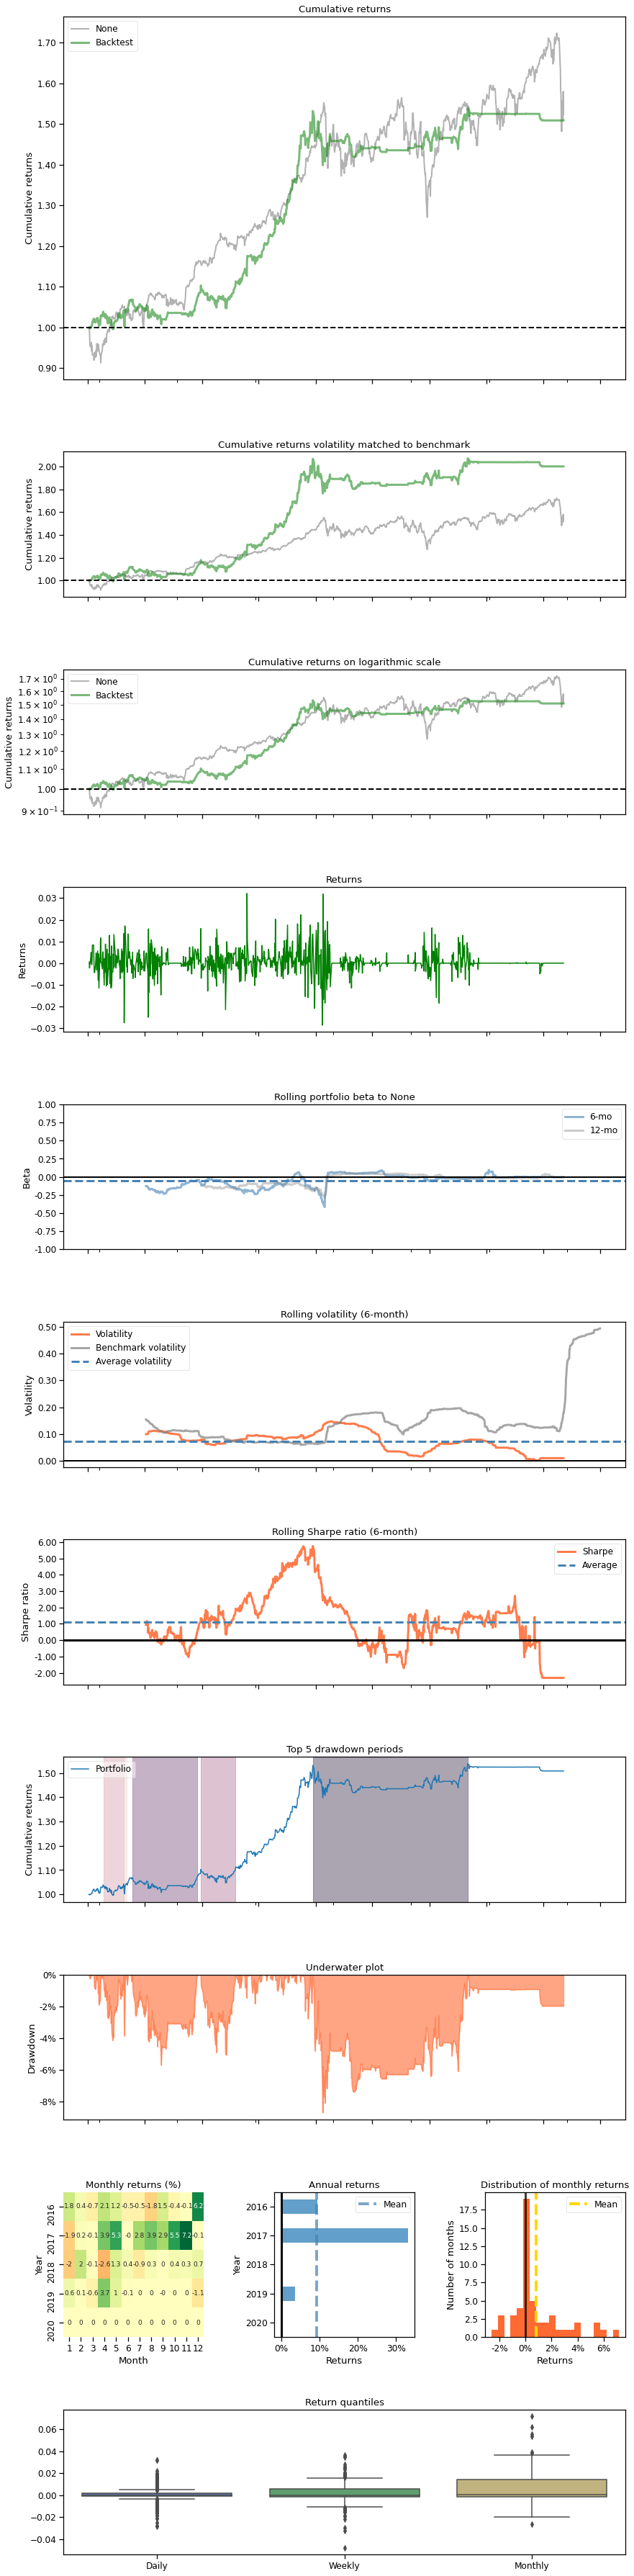

In [38]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_strat,
                                   benchmark_rets=dow_strat, set_context=False)